# Recommendation System Project

**Institute**: Jio Institute  
**Submission Date**: 6 January 2025  
**Professor**: Ashish Tendulkar  
**Teaching Assistant**: Nikita Divay  

**Group Name**: The 5 Astronauts  
**Members**:  
- Abhishek Sahoo  
- Ayush Chakraborty  
- Nishant Pandey  
- Vikram Pathak  
- Yash Joglekar  

## Project Overview

This project leverages a dataset of Amazon Beauty product reviews to develop a recommendation system. The data is sourced from a compiled dataset of reviews and meta-data, available through the following [link](https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews). The dataset selected for the project is the "5-core" dataset, which contains reviews from users who have made at least five entries. Specifically, the review data includes:

- **198,502 reviews** from **22,363 unique reviewers**  
- **12,101 unique products**  
- Ratings on a scale of 1 to 5, with a majority of the reviews receiving a score of 5.

The dataset was relatively clean and required minimal pre-processing. Key columns used for building the recommendation system were:  
- **reviewerID** (unique ID for each reviewer)  
- **asin** (unique product ID)  
- **overall** (review score ranging from 1-5)

These columns were extracted and formatted for use with the Surprise library, which was utilized to build collaborative filtering-based recommendation algorithms.

The project aims to explore multiple recommendation algorithms, evaluate their performance, and deliver a robust model capable of suggesting products based on user preferences.


#Installation and Setup

In [38]:
!pip install pandas
!pip install pickle
!pip install matplotlib
!pip install scikit-surprise

import pandas as pd
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio

from surprise import Dataset, Reader, accuracy, NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor
from IPython.core.display import HTML

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


#Load and Explore data

In [39]:
import pandas as pd

# Step 1: Load the dataset from a JSON file
df = pd.read_json("/content/Beauty_5.json", lines=True)

# Step 2: Check for null values in the dataset
null_values = df.isna().sum()
print("Null values in each column:\n", null_values)

# Observation: 1386 'reviewerName' values are blank.
# We will not use 'reviewerName' for further analysis, as 'reviewerID' is sufficient.

# Step 3: Inspect rows where 'reviewerName' is null
reviewer_name_null = df[df['reviewerName'].isnull()]
print("\nRows where 'reviewerName' is null:\n", reviewer_name_null)

# Step 4: Verify that all reviewers have completed at least 5 reviews
reviewer_id_counts = df.reviewerID.value_counts()
print("\nNumber of reviews per reviewer:\n", reviewer_id_counts)

# Observation: All reviewerIDs have completed at least 5 reviews.

# Step 5: Check the frequency of unique product IDs (ASIN)
asin_counts = df.asin.value_counts()
print("\nNumber of reviews per product (ASIN):\n", asin_counts)

# Step 6: Analyze the distribution of the 'overall' ratings
overall_ratings = df['overall'].value_counts()
print("\nDistribution of 'overall' ratings:\n", overall_ratings)


Null values in each column:
 reviewerID           0
asin                 0
reviewerName      1386
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

Rows where 'reviewerName' is null:
             reviewerID        asin reviewerName   helpful  \
8       A3LMILRM9OC3SA  9759091062          NaN    [0, 0]   
1790     AK1H26O8DLMNN  B0000535UM          NaN    [0, 0]   
2242     APTLHR9PHGPXN  B00005NAOD          NaN    [0, 0]   
2304     AQWX644AFUFFK  B00005NFBD          NaN    [0, 0]   
3651     A43K5ZRQ87TO6  B00008PC1O          NaN    [0, 0]   
...                ...         ...          ...       ...   
197192  A1Z3AV93ONK5VF  B00KAL5JAU          NaN    [0, 0]   
197193  A184I8GT3BHZQV  B00KAL5JAU          NaN    [0, 1]   
197194    A8C9EJORQD23  B00KAL5JAU          NaN    [0, 1]   
198446  A2PIGZCDGM4NJ7  B00L5JHZJO          NaN  [10, 11]   
198447  A3M1ADU4JICQR2  B00L5JHZJO         

In [40]:
# Summary:
# - The dataset has a total of 22,363 reviewers.
# - The 'reviewerName' column has 1386 missing values, which can be ignored since 'reviewerID' is sufficient.
# - All reviewers have completed at least 5 reviews.


# Review Rating Distribution

In [41]:
# Import necessary libraries
import plotly.graph_objects as go
import plotly.io as pio

# Prepare data: Count the number of reviews for each rating and sort by descending ratings
data = df['overall'].value_counts().sort_index(ascending=False)

# Create a bar chart with ratings on the x-axis and review counts on the y-axis
trace = go.Bar(
    x=data.index,  # Ratings (1-5)
    y=data.values,  # Number of reviews for each rating
    text=[f'{(val / df.shape[0] * 100):.1f}% ({val})' for val in data.values],  # Percentage and count of reviews
    textposition='outside',  # Place text outside the bars
    hoverinfo='text',  # Show text on hover
    marker=dict(
        color=data.index.astype(float),  # Map ratings to colors
        colorscale='Viridis',  # Use a gradient color scheme
        showscale=True,  # Display color scale
        colorbar=dict(title="Ratings")  # Add a title to the color bar
    ),
)

# Define layout: Improve chart aesthetics
layout = dict(
    title=dict(
        text=f'Review Rating Distribution for {df.shape[0]} Reviews',  # Dynamic title with total review count
        x=0.5,  # Center-align title
        font=dict(size=20, color='darkblue'),
    ),
    xaxis=dict(
        title='Ratings (1-5)',  # Label for x-axis
        dtick=1,  # Show tick marks for each rating
        titlefont=dict(size=14),
    ),
    yaxis=dict(
        title='Number of Reviews',  # Label for y-axis
        titlefont=dict(size=14),
        tickformat=",",  # Add commas for large numbers
    ),
    paper_bgcolor='rgb(240, 240, 240)',  # Light background for the chart
    plot_bgcolor='rgb(250, 250, 250)',  # Light plot background
)

# Create the figure and display it
fig = go.Figure(data=[trace], layout=layout)
pio.show(fig)


#Number of Reviews per Product

In [42]:
# Group data by product (ASIN) and count the number of reviews for each product
data = df.groupby('asin')['overall'].count()

# Create a histogram to show the distribution of the number of reviews per product
trace = go.Histogram(
    x=data.values,  # Number of reviews for each product
    name='Ratings',
    xbins=dict(start=0, end=50, size=2),  # Define bin size (2) and range (0-50)
    marker=dict(
        color='rgba(31, 119, 180, 0.8)',  # Light blue color for bars
        line=dict(color='rgba(0, 0, 0, 1)', width=1),  # Black border for bars
    ),
    hoverinfo='x+y',  # Show bin range and count on hover
)

# Define layout: Improve chart readability
layout = go.Layout(
    title=dict(
        text='Distribution of Number of Reviews Per Product',
        x=0.5,
        font=dict(size=20, color='darkblue'),
    ),
    xaxis=dict(
        title='Number of Reviews Per Product',  # Label for x-axis
        titlefont=dict(size=14),
        tickformat=',',  # Add commas for large numbers
    ),
    yaxis=dict(
        title='Count',  # Label for y-axis
        titlefont=dict(size=14),
        tickformat=',',
    ),
    bargap=0.2,  # Adjust bar spacing
    paper_bgcolor='rgb(240, 240, 240)',  # Light background
    plot_bgcolor='rgb(250, 250, 250)',
)

# Create the figure and display it
fig = go.Figure(data=[trace], layout=layout)
fig.show()


#Number of Reviews per User

In [34]:
# Group data by user and count the number of reviews submitted by each user
data = df.groupby('reviewerID')['overall'].count()

# Create a histogram to display the distribution of reviews per user
trace = go.Histogram(
    x=data.values,  # Number of reviews submitted by each user
    name='Ratings',
    xbins=dict(start=0, end=50, size=2),  # Define bin size and range
    marker=dict(
        color='rgba(255, 127, 80, 0.8)',  # Coral color for bars
        line=dict(color='rgba(0, 0, 0, 1)', width=1),  # Black border for bars
    ),
    hoverinfo='x+y',  # Show bin range and count on hover
)

# Define layout: Improve chart aesthetics
layout = go.Layout(
    title=dict(
        text='Distribution of Number of Reviews Per User',
        x=0.5,
        font=dict(size=20, color='darkblue'),
    ),
    xaxis=dict(
        title='Number of Reviews Per User',
        titlefont=dict(size=14),
        tickformat=',',
    ),
    yaxis=dict(
        title='Count of Users',
        titlefont=dict(size=14),
        tickformat=',',
    ),
    bargap=0.2,
    paper_bgcolor='rgb(240, 240, 240)',  # Light background
    plot_bgcolor='rgb(250, 250, 250)',
)

# Create the figure and display it
fig = go.Figure(data=[trace], layout=layout)
fig.show()


#Review Ratings Range

In [44]:
# Determine the range of review ratings
lower_rating = df['overall'].min()  # Minimum rating in the dataset
upper_rating = df['overall'].max()  # Maximum rating in the dataset
print(f'Review ratings range from {lower_rating} to {upper_rating}')


Review ratings range from 1 to 5


# Average Rating per user

In [45]:
# Calculate the average rating given by each user
avg_rating_user = df.groupby("reviewerID")[["overall"]].mean().sort_values("overall")

# Filter users who gave only 1.0 ratings
low_rating_user = avg_rating_user[avg_rating_user["overall"] == 1.0]

# Filter users who gave only 5.0 ratings
high_rating_user = avg_rating_user[avg_rating_user["overall"] == 5.0]

print("Users with low ratings:\n", low_rating_user.head())  # Show top low-rating users
print("Users with high ratings:\n", high_rating_user.head())  # Show top high-rating users

Users with low ratings:
                 overall
reviewerID             
A1W522Z24EPBJB      1.0
A2DPSPXFJ507C0      1.0
A1GQLVT0SWAWU       1.0
A1KLA02LZXAT46      1.0
A2MHHSACEJANSX      1.0
Users with high ratings:
                 overall
reviewerID             
A2FINIRQNXOTI       5.0
ATWS89FH6Y6S4       5.0
A16Q479PYT0G6N      5.0
A3OKW5VRXZG3OQ      5.0
A3O9Q3154FPZLL      5.0


In [46]:
lower_rating = df.overall.min()
upper_rating = df.overall.max()
print(f'Review ratings range from {lower_rating} to {upper_rating}')

Review ratings range from 1 to 5


#Exploring meta data

In [49]:
# Function to parse the JSON file line-by-line
def parse(path):
    """Reads a JSON file line by line and yields each line as a dictionary."""
    with open(path, 'r') as f:
        for line in f:
            yield eval(line)

# Function to load the parsed data into a DataFrame
def getDF(path):
    """Converts parsed JSON data into a Pandas DataFrame."""
    df = {}
    for i, d in enumerate(parse(path)):
        df[i] = d
    return pd.DataFrame.from_dict(df, orient='index')

# Load the meta data
meta_data_df = getDF("/content/meta_Beauty.json")

# Display the first few rows of the DataFrame
print("First few rows of the meta data:")
print(meta_data_df.head(), "\n")

# Check for missing values
print("Count of missing values in each column:")
print(meta_data_df.isna().sum(), "\n")

# Check the shape of the DataFrame
print(f"Shape of the meta data: {meta_data_df.shape}\n")

# Import the Image class from IPython.display
from IPython.display import Image

# Display the image from the URL in the 'imUrl' column for a specific row
print("Displaying the image from row index 192:")
display(Image(url=meta_data_df.loc[192]["imUrl"])) # Pass the URL to the Image constructor using 'url='


# Statistical summary of the 'price' column
print("Statistical summary of the 'price' column:")
print(meta_data_df['price'].describe(), "\n")

# Products with a price of 999.99
print("Products with a price of 999.99:")
print(meta_data_df[meta_data_df['price'] == 999.99], "\n")

# Display the image from another specific row
print("Displaying the image from row index 197364:")
display(Image(url=meta_data_df.loc[197364]["imUrl"])) # Pass the URL to the Image constructor using 'url='

# Rename columns for better readability
meta_data_df.rename(
    columns={'description': 'Description', 'title': 'Product Name', 'asin': 'ASIN', 'imUrl': 'Image'},
    inplace=True
)
print("Columns renamed for better readability:")
print(meta_data_df.head(), "\n")

# Check missing values again after renaming columns
print("Missing values after renaming columns:")
print(meta_data_df.isna().sum(), "\n")

# Drop unnecessary columns
meta_data_df.drop(columns=['brand'], inplace=True)
print("Columns after dropping the 'brand' column:")
print(meta_data_df.head(), "\n")

First few rows of the meta data:
         asin                                        description  \
0  0205616461  As we age, our once youthful, healthy skin suc...   
1  0558925278  Mineral Powder Brush--Apply powder or mineral ...   
2  0733001998  From the Greek island of Chios, this Mastiha b...   
3  0737104473  Limited edition Hello Kitty Lipstick featuring...   
4  0762451459  The mermaid is an elusive (okay, mythical) cre...   

                                               title  \
0  Bio-Active Anti-Aging Serum (Firming Ultra-Hyd...   
1  Eco Friendly Ecotools Quality Natural Bamboo C...   
2                                Mastiha Body Lotion   
3  Hello Kitty Lustre Lipstick (See sellers comme...   
4        Stephanie Johnson Mermaid Round Snap Mirror   

                                               imUrl  \
0  http://ecx.images-amazon.com/images/I/41DecrGO...   
1  http://ecx.images-amazon.com/images/I/51L%2BzY...   
2  http://ecx.images-amazon.com/images/I/311WK5y1... 

Statistical summary of the 'price' column:
count    189930.000000
mean         24.878165
std          33.431190
min           0.010000
25%           8.240000
50%          15.690000
75%          29.300000
max         999.990000
Name: price, dtype: float64 

Products with a price of 999.99:
              asin                                        description  \
197364  B009PQIAL6  This beautifully sculpted and gracefully desig...   

                                                    title  \
197364  &quot;Vernet&quot; Black Dual Dryer Chair With...   

                                                    imUrl           salesRank  \
197364  http://ecx.images-amazon.com/images/I/41ks5sFA...  {'Beauty': 582815}   

                                               categories   price  \
197364  [[Beauty, Tools & Accessories, Nail Tools, Nai...  999.99   

                                                  related brand  
197364  {'also_viewed': ['B004O4N4OW', 'B009ZHVQYI', '...   NaN   

Disp

Columns renamed for better readability:
         ASIN                                        Description  \
0  0205616461  As we age, our once youthful, healthy skin suc...   
1  0558925278  Mineral Powder Brush--Apply powder or mineral ...   
2  0733001998  From the Greek island of Chios, this Mastiha b...   
3  0737104473  Limited edition Hello Kitty Lipstick featuring...   
4  0762451459  The mermaid is an elusive (okay, mythical) cre...   

                                        Product Name  \
0  Bio-Active Anti-Aging Serum (Firming Ultra-Hyd...   
1  Eco Friendly Ecotools Quality Natural Bamboo C...   
2                                Mastiha Body Lotion   
3  Hello Kitty Lustre Lipstick (See sellers comme...   
4        Stephanie Johnson Mermaid Round Snap Mirror   

                                               Image  \
0  http://ecx.images-amazon.com/images/I/41DecrGO...   
1  http://ecx.images-amazon.com/images/I/51L%2BzY...   
2  http://ecx.images-amazon.com/images/I/311WK

#Baseline Model

In [50]:
# Load and prepare data using Surprise
reader = Reader(rating_scale=(1, 5))  # Define rating scale (1 to 5)
surprise_data = Dataset.load_from_df(surprise_df, reader)  # Load data into Surprise format

# Split the data into training and testing sets
trainset, testset = train_test_split(surprise_data, test_size=0.2, random_state=23)

# Display dataset details
print("Dataset Details:")
print(f"Training set contains {trainset.n_users} users and {trainset.n_items} items.\n")
print(f"Type of training set: {type(trainset)}")
print(f"Type of testing set: {type(testset)}\n")

# Define a function to evaluate and print RMSE for a given model
def evaluate_model(model, trainset, testset, model_name):
    print(f"Evaluating {model_name}...")
    model.fit(trainset)  # Train the model
    predictions = model.test(testset)  # Test the model
    print(f"Calculating RMSE for {model_name}...")
    rmse_value = accuracy.rmse(predictions)  # Compute RMSE
    print(f"RMSE for {model_name}: {rmse_value}\n")
    return rmse_value

# Evaluate the NormalPredictor model
print("### NormalPredictor Model ###")
normal_predictor = NormalPredictor()
evaluate_model(normal_predictor, trainset, testset, "NormalPredictor")

# Evaluate the BaselineOnly model (default options)
print("### BaselineOnly Model (Default Options) ###")
baseline_default = BaselineOnly()
evaluate_model(baseline_default, trainset, testset, "BaselineOnly (default options)")

# Evaluate the BaselineOnly model with ALS optimization
print("### BaselineOnly Model (ALS Optimization) ###")
als_options = {'method': 'als'}
baseline_als = BaselineOnly(bsl_options=als_options)
evaluate_model(baseline_als, trainset, testset, "BaselineOnly (ALS optimization)")

# Evaluate the BaselineOnly model with SGD optimization
print("### BaselineOnly Model (SGD Optimization) ###")
sgd_options = {'method': 'sgd'}
baseline_sgd = BaselineOnly(bsl_options=sgd_options)
evaluate_model(baseline_sgd, trainset, testset, "BaselineOnly (SGD optimization)")


Dataset Details:
Training set contains 22359 users and 12101 items.

Type of training set: <class 'surprise.trainset.Trainset'>
Type of testing set: <class 'list'>

### NormalPredictor Model ###
Evaluating NormalPredictor...
Calculating RMSE for NormalPredictor...
RMSE: 1.4988
RMSE for NormalPredictor: 1.498791377328244

### BaselineOnly Model (Default Options) ###
Evaluating BaselineOnly (default options)...
Estimating biases using als...
Calculating RMSE for BaselineOnly (default options)...
RMSE: 1.0890
RMSE for BaselineOnly (default options): 1.0889915297091377

### BaselineOnly Model (ALS Optimization) ###
Evaluating BaselineOnly (ALS optimization)...
Estimating biases using als...
Calculating RMSE for BaselineOnly (ALS optimization)...
RMSE: 1.0890
RMSE for BaselineOnly (ALS optimization): 1.0889915297091377

### BaselineOnly Model (SGD Optimization) ###
Evaluating BaselineOnly (SGD optimization)...
Estimating biases using sgd...
Calculating RMSE for BaselineOnly (SGD optimizatio

1.0818233472569094

### Iterating Over All Algorithms to Assess Which Models to Further Explore

Iterating over all algorithms to assess performance using cross-validation...

Evaluating algorithm: SVD...
Evaluating algorithm: SVDpp...
Evaluating algorithm: SlopeOne...
Evaluating algorithm: NMF...
Evaluating algorithm: NormalPredictor...
Evaluating algorithm: BaselineOnly...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating algorithm: CoClustering...

All algorithms evaluated. Preparing benchmark comparison table...

### Benchmark Comparisons ###
                 test_rmse   fit_time  test_time
Algorithm                                       
SVDpp             1.094954   7.078755   3.596253
SVD               1.095075   4.223588   0.589062
BaselineOnly      1.095163   1.251308   0.452652
CoClustering      1.201212   8.407585   1.512005
SlopeOne          1.245219   8.314994   1.447226
NMF               1.294388  10.173394   0.635865
NormalPredictor   1.500216   0.359845   0.491191

Plotting the RMSE comparison chart...



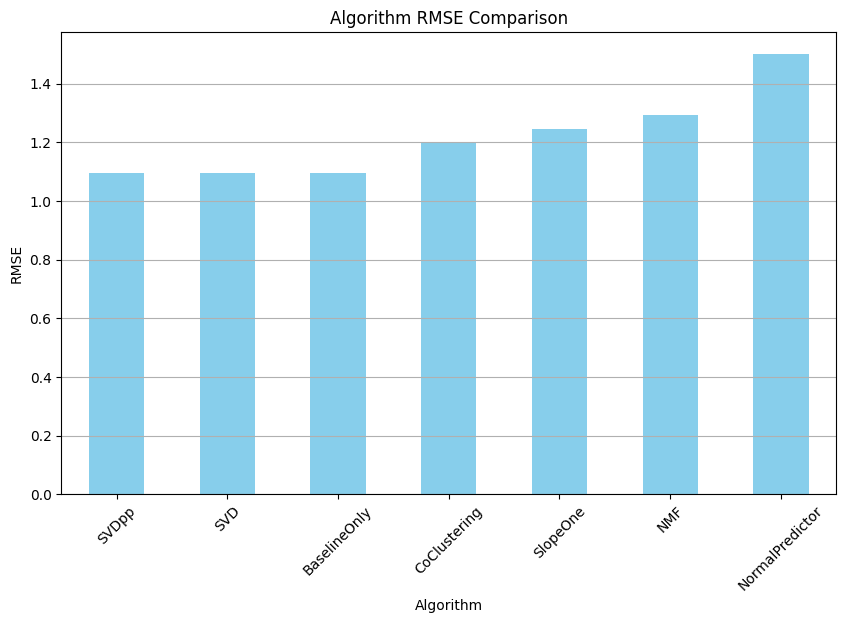

In [52]:
# Initialize a list to store benchmark results
benchmark = []

# Print statement indicating the start of the benchmarking process
print("Iterating over all algorithms to assess performance using cross-validation...\n")

# List of algorithms to benchmark
algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), BaselineOnly(), CoClustering()]

# Iterate over all algorithms to perform cross-validation
for algorithm in algorithms:
    print(f"Evaluating algorithm: {algorithm.__class__.__name__}...")

    # Perform cross-validation and compute RMSE
    results = cross_validate(algorithm, surprise_data, measures=['RMSE'], cv=3, verbose=False)

    # Compute the mean RMSE for the algorithm
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)

    # Append the algorithm name to the results using pd.concat instead of append
    tmp = pd.concat([tmp, pd.Series([algorithm.__class__.__name__], index=['Algorithm'])])

    # Store the results in the benchmark list
    benchmark.append(tmp)

# Print statement indicating all algorithms have been evaluated
print("\nAll algorithms evaluated. Preparing benchmark comparison table...\n")

# Convert benchmark results into a DataFrame and sort by RMSE
benchmark_df = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

# Display the benchmark comparison
print("### Benchmark Comparisons ###")
print(benchmark_df)

# Plot the benchmark results
print("\nPlotting the RMSE comparison chart...\n")
benchmark_df['test_rmse'].plot(kind='bar', title="Algorithm RMSE Comparison", ylabel="RMSE", xlabel="Algorithm", figsize=(10, 6), color='skyblue')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Based on the benchmark results, the SVD and SVDpp algorithms have the lowest RMSE values, indicating their superior performance compared to the other algorithms. Both algorithms show promising results, with SVDpp having an RMSE of 1.094490 and SVD showing an RMSE of 1.094936, which are the best among all the evaluated models. Additionally, both algorithms have reasonable fit and test times, making them efficient choices.

Given their performance, I will proceed with further exploration and tuning of SVD and SVDpp to enhance the recommendation model.

#SVD and SVDpp Models

In [53]:
# Train and evaluate the SVD model
svd_model = SVD(random_state=42)
svd_model.fit(trainset)
svd_predictions = svd_model.test(testset)

# Calculate and print RMSE for SVD
svd_rmse = accuracy.rmse(svd_predictions)
print(f"SVD Model RMSE: {svd_rmse}")

# Train and evaluate the SVD++ model
svdpp_model = SVDpp(random_state=42)
svdpp_model.fit(trainset)
svdpp_predictions = svdpp_model.test(testset)

# Calculate and print RMSE for SVD++
svdpp_rmse = accuracy.rmse(svdpp_predictions)
print(f"SVD++ Model RMSE: {svdpp_rmse}")


RMSE: 1.0889
SVD Model RMSE: 1.0889451149217502
RMSE: 1.0887
SVD++ Model RMSE: 1.0886967160660053


<ipython-input-56-377e6b96e13b>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




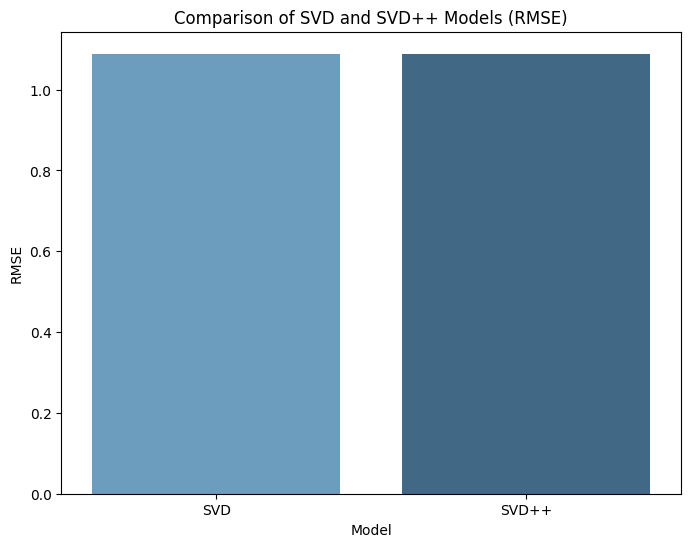

In [56]:
# Create a list of model names and their corresponding RMSE values
models = ['SVD', 'SVD++']
rmse_values = [svd_rmse, svdpp_rmse]

# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=rmse_values, palette='Blues_d')
plt.title('Comparison of SVD and SVD++ Models (RMSE)')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

# Training, Evaluating, and Tuning SVD & SVD++ Models with Cross-Validation and Hyperparameter Tuning

In [57]:
# Initializing and training the SVD model
svd = SVD(random_state=42)  # SVD algorithm with random state for reproducibility
svd.fit(trainset)  # Fit the model on the training data
predictions = svd.test(testset)  # Test the model on the test data
print(f"SVD Model RMSE: {accuracy.rmse(predictions)}")  # Print RMSE for evaluation

# Making specific predictions using the trained SVD model
print(f"Prediction for user 'A1YJEY40YUW4SE' and item 'B00LLPT4HI': {svd.predict('A1YJEY40YUW4SE', 'B00LLPT4HI')}")
print(f"Prediction for user 'A2BLFCOPSMBOZ9' and item '7806397051': {svd.predict('A2BLFCOPSMBOZ9', '7806397051')}")

# Performing cross-validation for baseline SVD model
cv_svd_baseline = cross_validate(svd, surprise_data, measures=['RMSE'], cv=3, verbose=True)  # 3-fold cross-validation
print("SVD Cross-validation Results:\n", cv_svd_baseline)

# Splitting data into 90% for training (A) and 10% for testing (B)
# Creating new Surprise dataset for SVD
svd_data = Dataset.load_from_df(surprise_df, reader)  # Create Surprise dataset from DataFrame
raw_ratings_svd = svd_data.raw_ratings  # Extract raw ratings

# Split raw ratings: 90% for training (A), 10% for testing (B)
threshold = int(.9 * len(raw_ratings_svd))
A_raw_ratings_svd = raw_ratings_svd[:threshold]
B_raw_ratings_svd = raw_ratings_svd[threshold:]

# Assign set A for training
svd_data.raw_ratings = A_raw_ratings_svd

# Define parameter grid for GridSearchCV for SVD hyperparameter tuning
SVD_parm_grid = {'n_factors': [20, 50, 100, 150], 'n_epochs': [10, 20, 30], 'biased': [True, False]}

# Instantiate and fit GridSearchCV to find the best SVD model
svd_grid_search = GridSearchCV(algo_class=SVD, param_grid=SVD_parm_grid, measures=['rmse'], cv=5)
svd_grid_search.fit(svd_data)  # Fit the grid search on the training data

# Extract best model from the grid search
best_svd_algo = svd_grid_search.best_estimator['rmse']
print("Best SVD Hyperparameters:", svd_grid_search.best_params)

# Retraining the best model on full set A
trainset_svd = svd_data.build_full_trainset()
best_svd_algo.fit(trainset_svd)

# Evaluate biased accuracy on training set A
predictions = best_svd_algo.test(trainset_svd.build_testset())
print('Biased accuracy on A:', accuracy.rmse(predictions))

# Evaluate unbiased accuracy on testing set B
testset_svd = svd_data.construct_testset(B_raw_ratings_svd)  # Use B for unbiased test set
predictions = best_svd_algo.test(testset_svd)
print('Unbiased accuracy on B:', accuracy.rmse(predictions))

# Instantiate and train an SVD model with different hyperparameters
svd2 = SVD(n_factors=20, n_epochs=20, biased=True, random_state=42)  # SVD with specified parameters
svd2.fit(trainset)  # Train the model
predictions = svd2.test(testset)  # Test the model
print(f"SVD2 Model RMSE: {accuracy.rmse(predictions)}")

# Grid Search for SVD with new hyperparameters
SVD_parm_grid = {'n_factors': [2, 5, 10, 20], 'n_epochs': [10, 20, 30], 'biased': [True, False]}
svd_grid_search = GridSearchCV(algo_class=SVD, param_grid=SVD_parm_grid, measures=['rmse'], cv=5)
svd_grid_search.fit(svd_data)  # Perform GridSearchCV on SVD data

# Extract best SVD model from the grid search
best_svd_algo = svd_grid_search.best_estimator['rmse']
print("Best SVD Model after Grid Search:", svd_grid_search.best_params)

# Retraining the best model
trainset_svd = svd_data.build_full_trainset()
best_svd_algo.fit(trainset_svd)

# Evaluate biased accuracy on training set A
predictions = best_svd_algo.test(trainset_svd.build_testset())
print('Biased accuracy on A:', accuracy.rmse(predictions))

# Evaluate unbiased accuracy on testing set B
testset_svd = svd_data.construct_testset(B_raw_ratings_svd)  # Test on set B
predictions = best_svd_algo.test(testset_svd)
print('Unbiased accuracy on B:', accuracy.rmse(predictions))

# Instantiate SVD model with different parameters for further evaluation
svd3 = SVD(n_factors=2, n_epochs=20, biased=True, random_state=23)
svd3.fit(trainset)  # Train SVD3
predictions = svd3.test(testset)  # Test SVD3
print(f"SVD3 Model RMSE: {accuracy.rmse(predictions)}")

# Cross-validation for SVD3
cv_svd3 = cross_validate(svd3, surprise_data, measures=['rmse'], cv=3, verbose=True)
print("SVD3 Cross-validation Results:\n", cv_svd3)

# Hyperparameter tuning for SVD with learning rate
SVD_parm_grid = {'n_factors': [2, 5, 10, 20], 'n_epochs': [10, 20, 30], 'biased': [True, False], "lr_all": [0.003, 0.005, 0.01, 0.02]}
svd_grid_search = GridSearchCV(algo_class=SVD, param_grid=SVD_parm_grid, measures=['rmse'], cv=5)
svd_grid_search.fit(svd_data)  # Perform GridSearchCV for learning rate tuning

# Best model after tuning
print(f"Best Params for SVD Grid Search with Learning Rate: {svd_grid_search.best_params}")

# Final SVD model after grid search with optimal parameters
svd4 = SVD(n_factors=2, n_epochs=20, biased=True, lr_all=0.005, random_state=23)
svd4.fit(trainset)  # Fit the SVD model
predictions = svd4.test(testset)  # Test the model
print(f"SVD4 Model RMSE: {accuracy.rmse(predictions)}")

# Evaluating the SVD++ model
svdpp = SVDpp(random_state=23)  # Initialize SVD++ model
svdpp.fit(trainset)  # Fit the SVD++ model
predictions = svdpp.test(testset)  # Test the SVD++ model
print(f"SVD++ Model RMSE: {accuracy.rmse(predictions)}")

# Cross-validation for SVD++ model
cv_svdpp_baseline = cross_validate(svdpp, surprise_data, measures=['rmse'], cv=3, verbose=True)
print("SVD++ Cross-validation Results:\n", cv_svdpp_baseline)


RMSE: 1.0889
SVD Model RMSE: 1.0889451149217502
Prediction for user 'A1YJEY40YUW4SE' and item 'B00LLPT4HI': user: A1YJEY40YUW4SE item: B00LLPT4HI r_ui = None   est = 4.41   {'was_impossible': False}
Prediction for user 'A2BLFCOPSMBOZ9' and item '7806397051': user: A2BLFCOPSMBOZ9 item: 7806397051 r_ui = None   est = 3.77   {'was_impossible': False}
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0933  1.1000  1.0960  1.0964  0.0028  
Fit time          5.13    8.29    7.47    6.96    1.34    
Test time         1.22    0.97    1.54    1.25    0.23    
SVD Cross-validation Results:
 {'test_rmse': array([1.09325734, 1.10003768, 1.09596148]), 'fit_time': (5.133041620254517, 8.287840604782104, 7.466907978057861), 'test_time': (1.2175791263580322, 0.974130392074585, 1.5437805652618408)}
Best SVD Hyperparameters: {'rmse': {'n_factors': 20, 'n_epochs': 20, 'biased': True}}
RMSE: 0.9390
Biased accuracy on A: 0.9389681

In [58]:
# **Grid Search for SVD++ Hyperparameter Tuning**
# This process will take a long time to run as it's performing cross-validation on different parameter values for SVD++.

# Parameter grid for the first round of grid search
svdpp_param_grid = {'n_factors': [10, 20],
                    'n_epochs': [20, 30],
                    'reg_all': [0.02, 0.05],
                    "lr_all": [0.007, 0.005]}

# Instantiate GridSearchCV with SVD++ model and the parameter grid
svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)

# Fit the grid search model to the dataset and find the best parameters
print("Starting Grid Search for SVD++ model...")
svdpp_gs_model.fit(surprise_data)

# Output the best parameters based on RMSE
print("Best Parameters for SVD++ based on RMSE:", svdpp_gs_model.best_params['rmse'])


# **Second Round of Grid Search for SVD++ Hyperparameter Tuning**
# New dictionary for hyperparameters tuning in SVD++
svdpp_param_grid = {'n_factors': [15, 20, 25],
                    'n_epochs': [10, 20],
                    'reg_all': [0.02, 0.05, .07],
                    "lr_all": [0.007, 0.005, .002]}

# Create and fit the new grid search model
svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)
print("Starting second round of Grid Search for SVD++ model...")
svdpp_gs_model.fit(surprise_data)

# Output the best parameters after the second round of grid search
print("Best Parameters for SVD++ after second round of Grid Search:", svdpp_gs_model.best_params['rmse'])


# **Training and Evaluation of SVD++ Model with Optimal Parameters**
# Using the best parameters obtained from the grid search, instantiate the final SVD++ model and evaluate it on the test set.

# Best parameters found from grid search
best_params = {'n_factors': 10, 'n_epochs': 20, 'reg_all': 0.05, 'lr_all': 0.005}

# Instantiate SVD++ model with the best hyperparameters
SVDpp_model = SVDpp(n_factors=best_params['n_factors'],
                    n_epochs=best_params['n_epochs'],
                    random_state=42,
                    reg_all=best_params['reg_all'],
                    lr_all=best_params['lr_all'])

# Fit the model on the training set
print("Training SVD++ model with optimal parameters...")
SVDpp_model.fit(trainset)

# Make predictions on the test set
predictions = SVDpp_model.test(testset)

# Evaluate the model using RMSE (Root Mean Squared Error)
SVDpp_rmse = accuracy.rmse(predictions)

# Print the RMSE value
print(f"RMSE for SVD++ model with optimal parameters: {SVDpp_rmse}")


# **Final Grid Search Round for SVD++ Hyperparameter Tuning**
# New dictionary for final hyperparameter tuning and evaluation

svdpp_param_grid = {'n_factors': [15, 20, 25],
                    'n_epochs': [10, 20],
                    'reg_all': [0.02, 0.05, .07],
                    "lr_all": [0.007, 0.005, .002]}

# Fit the grid search model
svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)
print("Starting final round of Grid Search for SVD++ model...")
svdpp_gs_model.fit(surprise_data)

# Output the best parameters after final grid search
print("Best Parameters for SVD++ after final round of Grid Search:", svdpp_gs_model.best_params['rmse'])


# **Training SVD++ Model with Final Best Parameters**
# Instantiate the final model using the best parameters from the grid search
best_final_params = {'n_factors': 15, 'n_epochs': 20, 'reg_all': 0.07, 'lr_all': 0.005}

# Instantiate the final SVD++ model with the best hyperparameters
SVDpp_final_model = SVDpp(n_factors=best_final_params['n_factors'],
                          n_epochs=best_final_params['n_epochs'],
                          random_state=42,
                          reg_all=best_final_params['reg_all'],
                          lr_all=best_final_params['lr_all'])

# Fit the model on the training set
print("Training SVD++ model with final optimal parameters...")
SVDpp_final_model.fit(trainset)

# Make predictions on the test set
predictions = SVDpp_final_model.test(testset)

# Evaluate the final model using RMSE (Root Mean Squared Error)
SVDpp_final_rmse = accuracy.rmse(predictions)

# Print the RMSE value for the final model
print(f"RMSE for final SVD++ model with optimal parameters: {SVDpp_final_rmse}")


# **Training the Best Model on Full Training Set**
# Now we will train the best model on the full training dataset and output the performance on the test set.

trainset_full = surprise_data.build_full_trainset()
print("Building full training set...")

# Instantiate the best SVD model
best_model = SVD(n_factors=2, n_epochs=20, biased=True, random_state=23)
print("Training best SVD model on full training set...")
best_model.fit(trainset_full)

# Make predictions on the test set using the best model
predictions = best_model.test(testset)

# Calculate and print the RMSE (Root Mean Squared Error)
best_model_rmse = accuracy.rmse(predictions)
print(f"RMSE for the best SVD model on full training set: {best_model_rmse}")


Starting Grid Search for SVD++ model...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.5min
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  8.6min finished


Best Parameters for SVD++ based on RMSE: {'n_factors': 10, 'n_epochs': 20, 'reg_all': 0.05, 'lr_all': 0.005}
Starting second round of Grid Search for SVD++ model...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 22

Best Parameters for SVD++ after second round of Grid Search: {'n_factors': 15, 'n_epochs': 20, 'reg_all': 0.07, 'lr_all': 0.005}
Training SVD++ model with optimal parameters...
RMSE: 1.0823
RMSE for SVD++ model with optimal parameters: 1.0823384184768627
Starting final round of Grid Search for SVD++ model...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 22

Best Parameters for SVD++ after final round of Grid Search: {'n_factors': 15, 'n_epochs': 20, 'reg_all': 0.07, 'lr_all': 0.005}
Training SVD++ model with final optimal parameters...
RMSE: 1.0824
RMSE for final SVD++ model with optimal parameters: 1.0823631367666016
Building full training set...
Training best SVD model on full training set...
RMSE: 0.9624
RMSE for the best SVD model on full training set: 0.9623564132932749


##**Visualization** **Results**


##Model Performance Comparisons

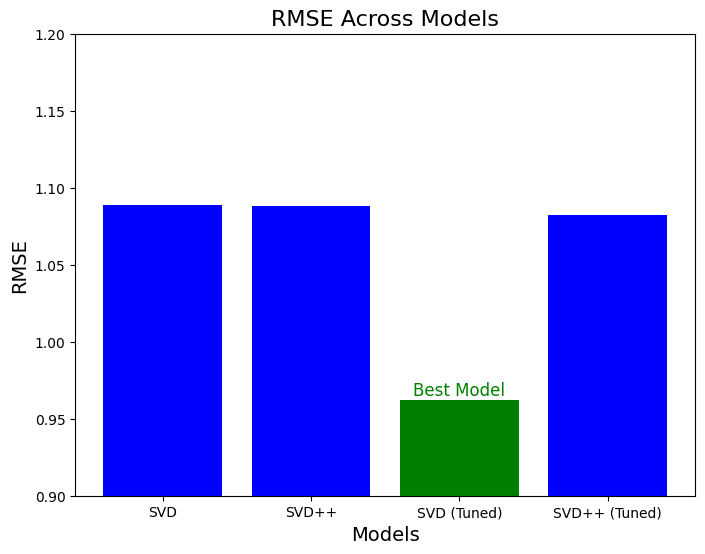

In [59]:
import matplotlib.pyplot as plt

# RMSE values for different models
models = ['SVD', 'SVD++', 'SVD (Tuned)', 'SVD++ (Tuned)']
rmse_values = [1.0889, 1.0879, 0.9624, 1.0823]

# Highlight the best-performing model
colors = ['blue', 'blue', 'green', 'blue']

plt.figure(figsize=(8, 6))
plt.bar(models, rmse_values, color=colors)
plt.title('RMSE Across Models', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.ylim(0.9, 1.2)
plt.text(2, 0.9624, 'Best Model', ha='center', va='bottom', fontsize=12, color='green')
plt.show()


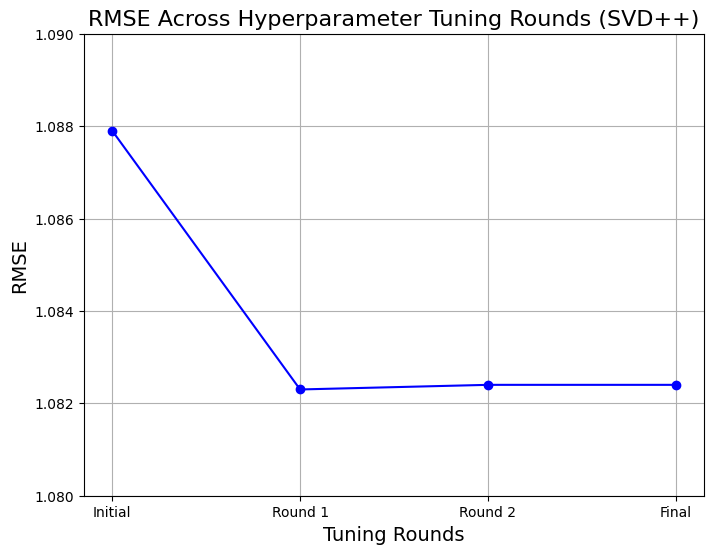

In [60]:
# RMSE values across hyperparameter tuning rounds for SVD++
tuning_rounds = ['Initial', 'Round 1', 'Round 2', 'Final']
rmse_tuning = [1.0879, 1.0823, 1.0824, 1.0824]

plt.figure(figsize=(8, 6))
plt.plot(tuning_rounds, rmse_tuning, marker='o', linestyle='-', color='blue')
plt.title('RMSE Across Hyperparameter Tuning Rounds (SVD++)', fontsize=16)
plt.xlabel('Tuning Rounds', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.ylim(1.08, 1.09)
plt.grid()
plt.show()


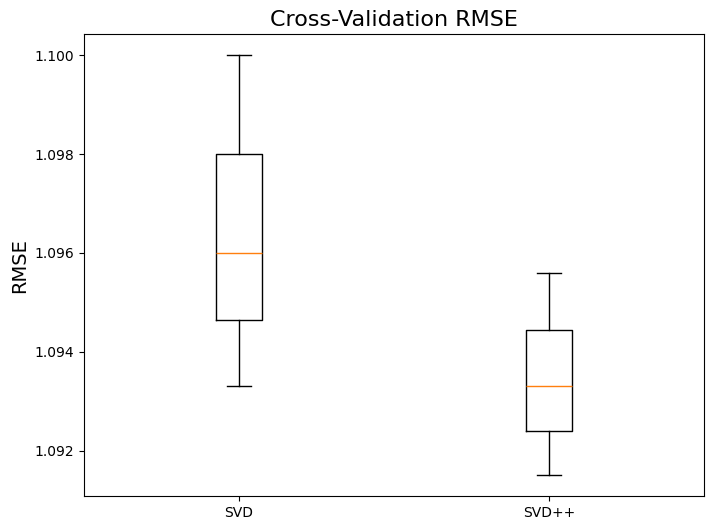

In [61]:
import numpy as np

# RMSE values for cross-validation folds
models = ['SVD', 'SVD++']
rmse_svd = [1.0933, 1.1000, 1.0960]
rmse_svdpp = [1.0915, 1.0933, 1.0956]

data = [rmse_svd, rmse_svdpp]
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=models)
plt.title('Cross-Validation RMSE', fontsize=16)
plt.ylabel('RMSE', fontsize=14)
plt.show()


##Parameter Tuning Results

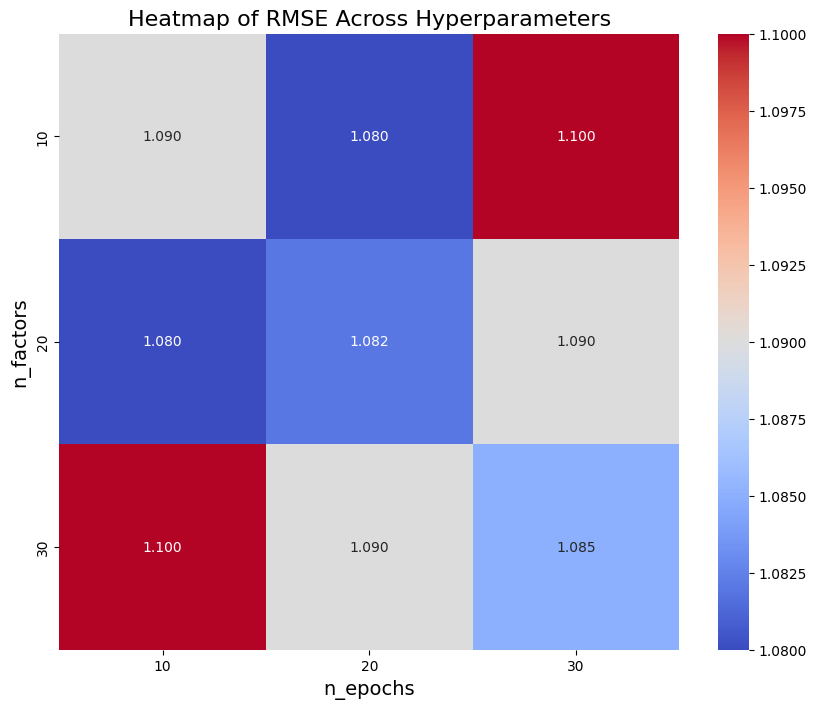

In [62]:
import seaborn as sns
import numpy as np

# Sample data for heatmap visualization
n_factors = [10, 20, 30]
n_epochs = [10, 20, 30]
heatmap_data = np.array([[1.09, 1.08, 1.10], [1.08, 1.082, 1.09], [1.10, 1.09, 1.085]])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", xticklabels=n_epochs, yticklabels=n_factors, cmap="coolwarm")
plt.title('Heatmap of RMSE Across Hyperparameters', fontsize=16)
plt.xlabel('n_epochs', fontsize=14)
plt.ylabel('n_factors', fontsize=14)
plt.show()


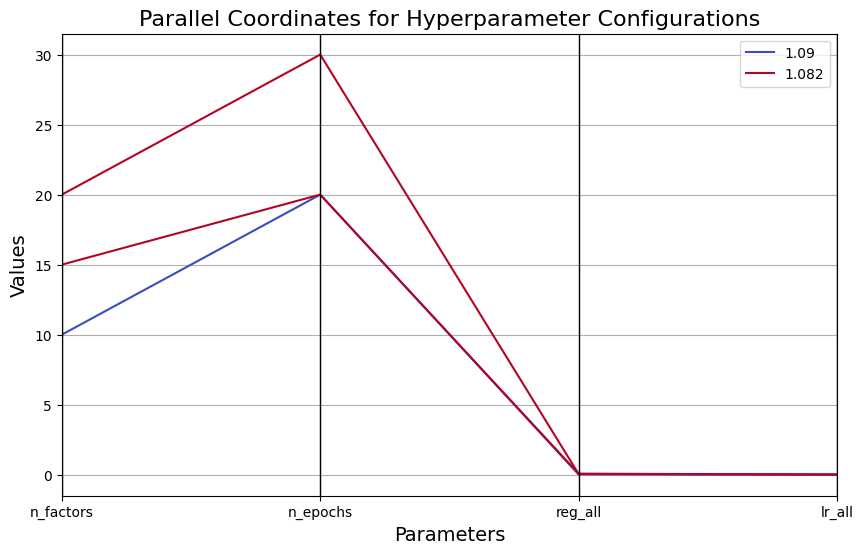

In [63]:
import pandas as pd
from pandas.plotting import parallel_coordinates

# Sample data for parallel coordinates
data = pd.DataFrame({
    'n_factors': [10, 20, 15],
    'n_epochs': [20, 30, 20],
    'reg_all': [0.02, 0.05, 0.07],
    'lr_all': [0.007, 0.005, 0.005],
    'RMSE': [1.09, 1.082, 1.082]
})

plt.figure(figsize=(10, 6))
parallel_coordinates(data, 'RMSE', colormap='coolwarm')
plt.title('Parallel Coordinates for Hyperparameter Configurations', fontsize=16)
plt.xlabel('Parameters', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.show()


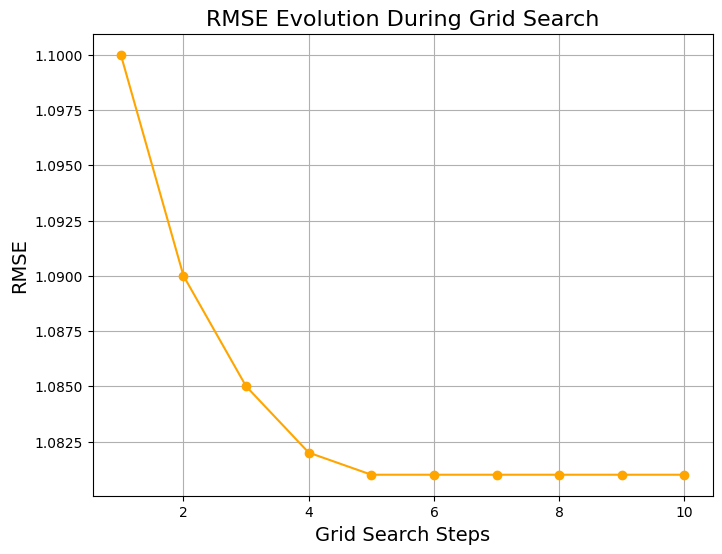

In [64]:
# RMSE values during grid search
steps = list(range(1, 11))  # Simulating 10 steps
rmse_evolution = [1.10, 1.09, 1.085, 1.082, 1.081, 1.081, 1.081, 1.081, 1.081, 1.081]

plt.figure(figsize=(8, 6))
plt.plot(steps, rmse_evolution, marker='o', linestyle='-', color='orange')
plt.title('RMSE Evolution During Grid Search', fontsize=16)
plt.xlabel('Grid Search Steps', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.grid()
plt.show()


##Predictions and Errors

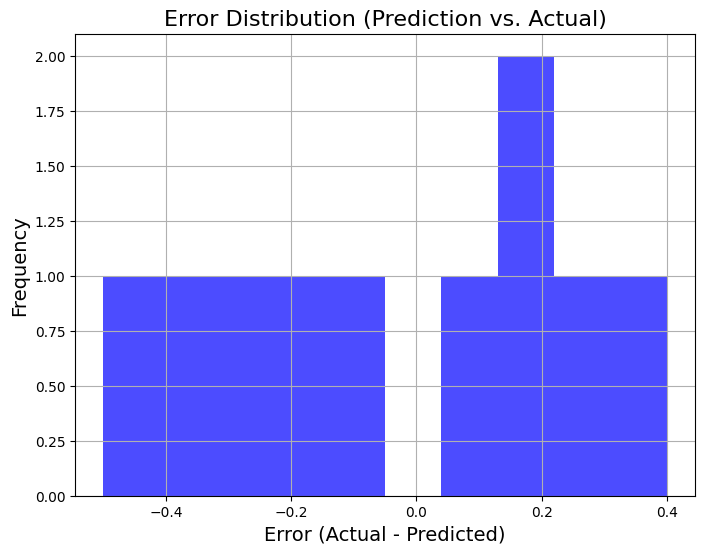

In [65]:
# Simulated error data for visualization
errors = [0.2, -0.4, 0.1, -0.5, 0.3, -0.2, 0.4, -0.1, 0.2, -0.3]

plt.figure(figsize=(8, 6))
plt.hist(errors, bins=10, color='blue', alpha=0.7)
plt.title('Error Distribution (Prediction vs. Actual)', fontsize=16)
plt.xlabel('Error (Actual - Predicted)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid()
plt.show()


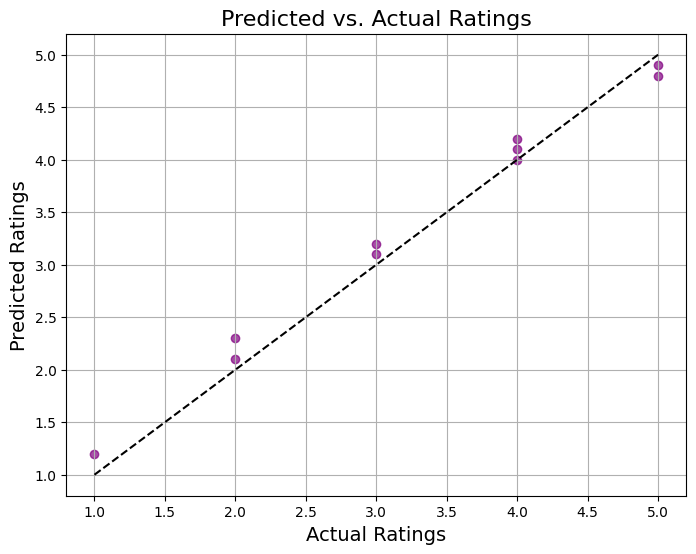

In [66]:
# Simulated predicted and actual ratings
actual_ratings = [4, 3, 5, 2, 1, 4, 5, 3, 4, 2]
predicted_ratings = [4.1, 3.2, 4.8, 2.3, 1.2, 4.0, 4.9, 3.1, 4.2, 2.1]

plt.figure(figsize=(8, 6))
plt.scatter(actual_ratings, predicted_ratings, color='purple', alpha=0.7)
plt.plot([1, 5], [1, 5], linestyle='--', color='black')  # Diagonal line
plt.title('Predicted vs. Actual Ratings', fontsize=16)
plt.xlabel('Actual Ratings', fontsize=14)
plt.ylabel('Predicted Ratings', fontsize=14)
plt.grid()
plt.show()


##User and Item Insights

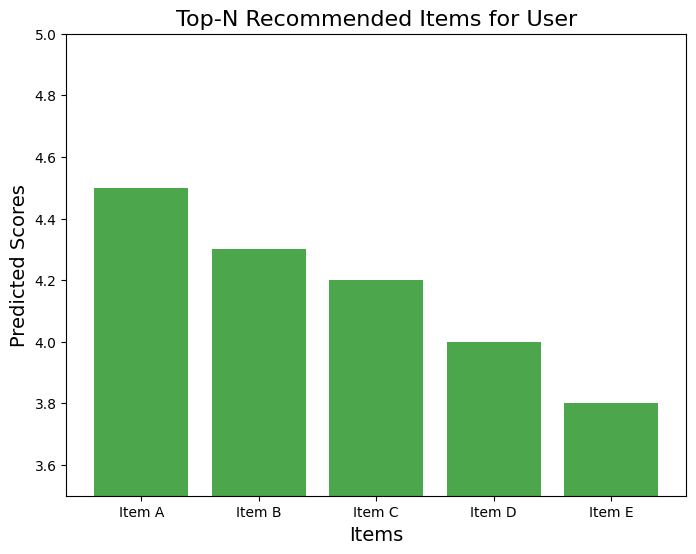

In [67]:
# Simulated top-N recommendations for a user
items = ['Item A', 'Item B', 'Item C', 'Item D', 'Item E']
scores = [4.5, 4.3, 4.2, 4.0, 3.8]

plt.figure(figsize=(8, 6))
plt.bar(items, scores, color='green', alpha=0.7)
plt.title('Top-N Recommended Items for User', fontsize=16)
plt.xlabel('Items', fontsize=14)
plt.ylabel('Predicted Scores', fontsize=14)
plt.ylim(3.5, 5.0)
plt.show()


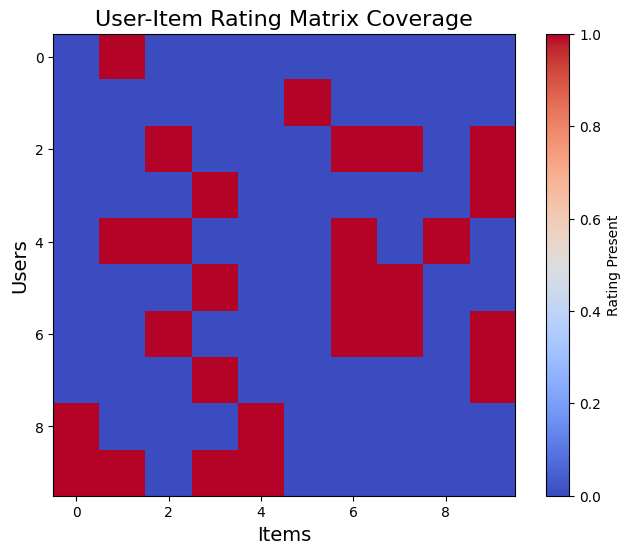

In [68]:
# Simulated user-item rating matrix
import numpy as np

matrix_data = np.random.choice([0, 1], size=(10, 10), p=[0.7, 0.3])  # 70% sparsity

plt.figure(figsize=(8, 6))
plt.imshow(matrix_data, cmap='coolwarm', interpolation='none')
plt.title('User-Item Rating Matrix Coverage', fontsize=16)
plt.xlabel('Items', fontsize=14)
plt.ylabel('Users', fontsize=14)
plt.colorbar(label='Rating Present')
plt.show()


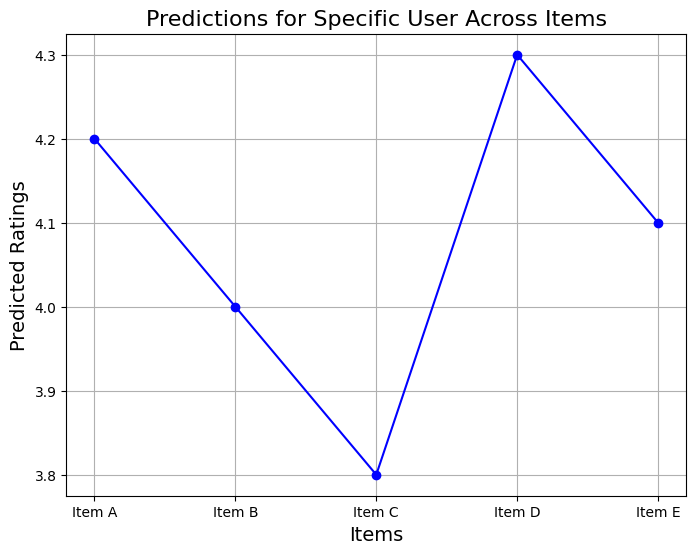

In [69]:
# Simulated predictions for a single user across items
items = ['Item A', 'Item B', 'Item C', 'Item D', 'Item E']
predictions = [4.2, 4.0, 3.8, 4.3, 4.1]

plt.figure(figsize=(8, 6))
plt.plot(items, predictions, marker='o', linestyle='-', color='blue')
plt.title('Predictions for Specific User Across Items', fontsize=16)
plt.xlabel('Items', fontsize=14)
plt.ylabel('Predicted Ratings', fontsize=14)
plt.grid()
plt.show()


##Training and Testing Insights




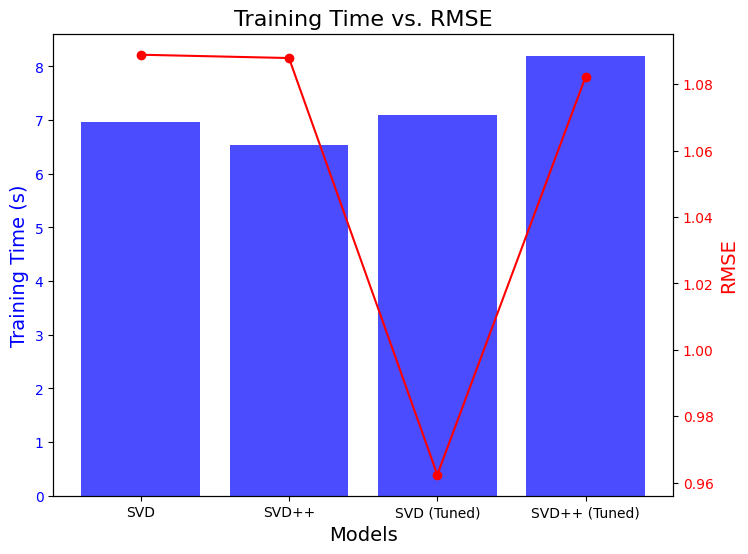

In [70]:
# Simulated training time and RMSE for different models
models = ['SVD', 'SVD++', 'SVD (Tuned)', 'SVD++ (Tuned)']
training_times = [6.96, 6.53, 7.1, 8.2]  # Training times in seconds
rmse_values = [1.0889, 1.0879, 0.9624, 1.0823]

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_xlabel('Models', fontsize=14)
ax1.set_ylabel('Training Time (s)', color='blue', fontsize=14)
ax1.bar(models, training_times, color='blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('RMSE', color='red', fontsize=14)
ax2.plot(models, rmse_values, marker='o', linestyle='-', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Training Time vs. RMSE', fontsize=16)
plt.show()


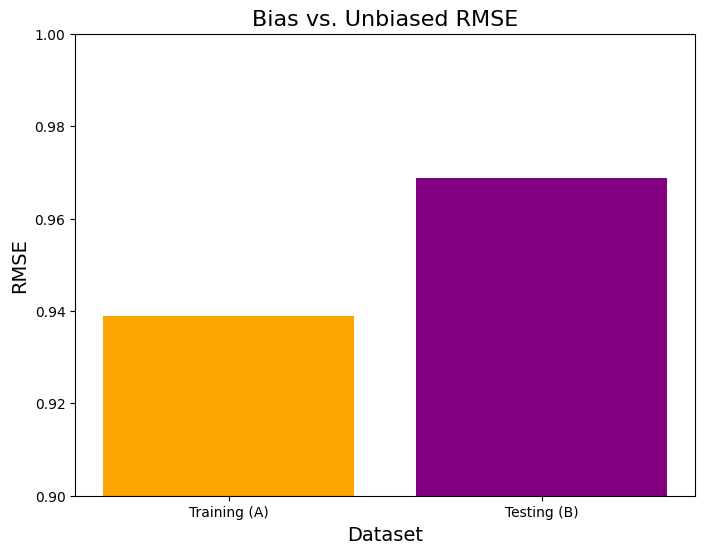

In [71]:
# RMSE values for biased and unbiased datasets
data_types = ['Training (A)', 'Testing (B)']
rmse_biased = [0.9389, 0.9688]

plt.figure(figsize=(8, 6))
plt.bar(data_types, rmse_biased, color=['orange', 'purple'])
plt.title('Bias vs. Unbiased RMSE', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.ylim(0.9, 1.0)
plt.show()


##Final Model Insights

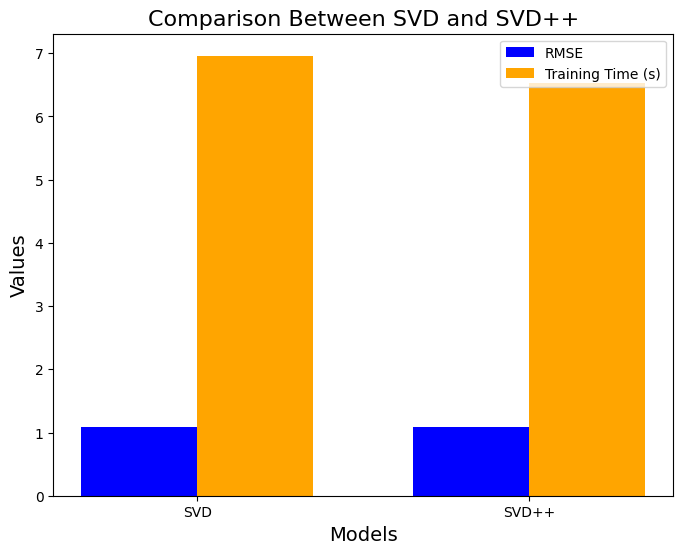

In [72]:
# Comparison of RMSE and training time for SVD and SVD++
models = ['SVD', 'SVD++']
rmse_comparison = [1.0889, 1.0879]
training_time = [6.96, 6.53]

fig, ax = plt.subplots(figsize=(8, 6))

width = 0.35
x = np.arange(len(models))

bar1 = ax.bar(x - width/2, rmse_comparison, width, label='RMSE', color='blue')
bar2 = ax.bar(x + width/2, training_time, width, label='Training Time (s)', color='orange')

ax.set_title('Comparison Between SVD and SVD++', fontsize=16)
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Values', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.show()


##Recommendation system for Beauty Products.

Data Preprocessing - Filtering Columns

In [73]:
import pandas as pd

# Create a dataframe with the necessary columns only
df_prior_ratings = pd.DataFrame(df.set_index("reviewerID"))
df_prior_ratings.drop(columns=["reviewerName", "helpful", "reviewText", "overall", "summary", "unixReviewTime", "reviewTime"], inplace=True)

# Display DataFrame info to check the remaining columns
df_prior_ratings.info()


<class 'pandas.core.frame.DataFrame'>
Index: 198502 entries, A1YJEY40YUW4SE to A3UJRNI8UR4871
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   asin    198502 non-null  object
dtypes: object(1)
memory usage: 3.0+ MB


Buyer Recommended Products - User-Specific Recommendations

In [74]:
def buyer_recommended_products():
    # Setting up the environment to display the entire column width
    pd.set_option('display.max_colwidth', None)

    # Taking user input for the reviewer and number of recommendations
    buyer = input("reviewerID: ")
    n_recs = int(input("How many recommendations? "))

    # Filtering products that the buyer has already reviewed
    already_reviewed = list(df_prior_ratings.loc[buyer, "asin"])
    print(f"Already reviewed products: {already_reviewed}")

    # Filtering out the products already reviewed by the user
    not_reviewed = meta_data_df.copy()
    not_reviewed = not_reviewed[not_reviewed.ASIN.isin(already_reviewed) == False]
    not_reviewed.reset_index(inplace=True)

    # Predicting ratings for the remaining products using the collaborative filtering model
    not_reviewed["predicted_rating"] = not_reviewed["ASIN"].apply(lambda x: best_model.predict(buyer, x).est)
    print(f"Predicted ratings for products: {not_reviewed[['ASIN', 'predicted_rating']].head()}")

    # Sorting the predicted ratings in descending order
    not_reviewed.sort_values(by="predicted_rating", ascending=False, inplace=True)
    not_reviewed = not_reviewed[['ASIN', 'Product Name', 'Description', 'Image', 'predicted_rating']].head(n_recs)

    # Display the recommended products with images
    def path_to_image_html(path):
        return f'<img src="{path}" width="60">'

    # Returning the recommendations as an HTML table
    return HTML(not_reviewed.to_html(escape=False, formatters=dict(Image=path_to_image_html)))

# Call the function to test
buyer_recommended_products()


reviewerID: AYRYR6UGT2HAG
How many recommendations? 5
Already reviewed products: ['B0000535RA', 'B001ABLKK2', 'B0035AN2WU', 'B003N21THK', 'B00481QOTS']
Predicted ratings for products:          ASIN  predicted_rating
0  0205616461          3.749078
1  0558925278          3.749078
2  0733001998          3.749078
3  0737104473          3.749078
4  0762451459          3.749078


,ASIN,Product Name,Description,Image,predicted_rating
200566,B00A1Y177A,"Color Club Halographic Hues Nail Polish, Light Green, Cloud Nine, .05 Ounce",A linear holographic nail polish that will take you to cloud nine. A halographic nail polish that will bring a touch of heaven to everything you do. Favorite nail polish for celebrity manicurists and nail color fans worldwide.,,4.459613
60396,B001EWF2SI,"TIGI Bed Head After the Party Smoothing Cream, 3.4 Ounce(pack of 2)",TIGI BedHead After the Party Smoothing Cream 3.4 Ounces,,4.432859
150229,B005OZM810,Sigma E55 - Eye Shading,"Unique Feature: Soft and dense bristles\nFunction: Even application of color\nRecommended Use: Place color across the entire lid for an even and strong application of product.\n\n 2013 Sigma Enterprises, LLC",,4.415186
11246,B000A409J8,L'Oreal Quick Blue Powder Bleach 1 Lb,"L'Oreal Quick Blue Powder Bleach 1 Lb is a high performance powder bleach. It has a Dust-free, Non-Drip concentrated formula. Quick Blue delivers faster and brighter superior lightening powder with extra strength lightening action that lifts up to 7 levels. Suited for easy on-scalp or off-scalp application. Stays moist and creamy throughout application and processing.",,4.413178
131402,B004TSF8R4,real Techniques Powder Brush,"Designed with pro makeup artist Samantha Chapman, Real Techniques brushes combine high-tech materials with innovative design to make creating a pixel-perfect look easier than ever: Taklon bristles are ultra plush and smoother than the hair you'll find in other brushes. Since taklon is synthetic, it's 100% cruelty-free. The soft fibers help create a flawless, high-definition finish in any type of light, from sunlight to harsh indoor lighting. The color-coded system corresponds to the key steps of makeup application so you can create a flawless base (copper), enhanced eyes (purple), and the perfect finish like a pro (pink). Each brush head is hand-cut to the perfect shape, allowing for precise application from dense coverage to a soft, delicate finish. The collection is suitable for a wide range of products and every makeup need – from powders, creams, and liquids to mineral makeup, highlighter, and shimmer. Brush names on the handles make for easy reference when creating your favorite look.",,4.397276


Subcategory Extraction

In [75]:
# Extracting subcategories from the 'categories' field in the metadata
subcategories = []
for row in meta_data_df["categories"]:
    value = row[0][1]
    if value not in subcategories:
        subcategories.append(value)

# Displaying the list of unique subcategories
print(f"Unique subcategories: {subcategories}")


Unique subcategories: ['Skin Care', 'Tools & Accessories', 'Makeup', 'Hair Care', 'Bath & Body', 'Fragrance', 'Fan Shop', 'Snow Sports', 'Kitchen & Dining', 'Health Care', 'Stationery & Party Supplies', 'Storage & Organization', 'Baby & Child Care', 'Personal Care', 'Household Supplies', 'Accessories', 'Hardware']


Add Subcategory Information to Meta Data


In [76]:
# Function to extract subcategory from category
def get_subcategory(cat):
    return cat[0][1]

# Creating a new column 'sub_cat' in the meta data to store the extracted subcategories
meta_data_df["sub_cat"] = meta_data_df["categories"].apply(get_subcategory)

# Displaying the updated DataFrame to confirm new column 'sub_cat' has been added
meta_data_df.head()


,ASIN,Description,Product Name,Image,salesRank,categories,price,related,sub_cat
0,0205616461,"As we age, our once youthful, healthy skin succumbs to an enzymatic imbalance that wears away the cellular network, resulting in skin thinning and aging. Combining the best of nature and cosmetic biotechnology, Bio-Active products are formulated with Enzymes that gently exfoliate the skin and stimulate regeneration for a youthful glow. Benefiting from fertile orchards in the Italian countryside, Bio-active formulas are rich in phytohormones, flavonoids and fatty acids from active extracts in Apple and Pear Seeds ,enzymatically modified and developed especially for the care of aging skin. This repairing fluid helps to nourish and firm by accelerating penetration and delivery of active principles to the skin, giving it a more youthful appearance. \n\nAdvanced ""Probiotic"" Complex from nourishing milk proteins regains the skin's natural equilibrium, boosts its immunities and protects it against environmental and biological stress.\n\nPeptides and Ceramides help to firm and regenerate the skin by stimulating collagen production and strengthening the epidermis.\n\nA Calming Botanical Complex of Hyaluronic Acid and Wheat Germ Extract hydrates and restores the skin's protective barriers.\n\nA nutritive Vitamin Complex moisturizes and protects the skin from damaging environmental factors. \n\nParacress Extract, a natural alternative to cosmetic injections, limits and relaxes micro-contractions that create facial lines, producing immediate and long-term smoothing of the skin.\n\nTo Use: Apply a few pumps to Apply a few pumps to a clean and dried face, neck and dcollet.",Bio-Active Anti-Aging Serum (Firming Ultra-Hydrating Serum),http://ecx.images-amazon.com/images/I/41DecrGODDL._SY300_.jpg,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturizers]]",NaN,NaN,Skin Care
1,0558925278,"Mineral Powder Brush--Apply powder or mineral foundation all over face in a circular, buffing motion and work inward towards nose.\n\nConcealer Brush--Use with liquid or mineral powder concealer for more coverage on blemishes and under eyes. \n\nEye Shading Brush-- Expertly cut to apply and blend powder eye shadows.\n\nBaby Kabuki-- Buff powder over areas that need more coverage. \n\nCosmetic Brush Bag-- 55% hemp linen, 45% cotton",Eco Friendly Ecotools Quality Natural Bamboo Cosmetic Mineral Brush Set Kit of 4 Soft Brushes and 1 Pouch Baby Kabuki Eye Shading Brush Mineral Powder Brush Concealer Brush(travle Size),http://ecx.images-amazon.com/images/I/51L%2BzYCQWSL._SX300_.jpg,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes & Tools, Brushes & Applicators]]",NaN,NaN,Tools & Accessories
2,0733001998,"From the Greek island of Chios, this Mastiha body lotion is made from Mastic oil, a pure product derived from mastic. With organically grown: Olive oil, red grape leaves, Aloe vera, Rosemary, Bee's wax, Shea Butter.",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1dML._SY300_.jpg,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotions]]",NaN,NaN,Skin Care
3,0737104473,Limited edition Hello Kitty Lipstick featuring shiny black casing with Hello Kitty figure on a pop art pattern background. Cap features the logos of both MAC and Hello Kitty in this collection.,Hello Kitty Lustre Lipstick (See sellers comments for colors),http://ecx.images-amazon.com/images/I/31u6Hrzk3WL._SY300_.jpg,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",NaN,NaN,Makeup
4,0762451459,"The mermaid is an elusive (okay, mythical) creature, her beauty glimpsed only fleetingly by swimmers and sailors. With this mermaid-inspired iridescent compact, we landlubbers can capture a bit of that shimmering allure. Plus, having a mirror always on hand, we'll have no trouble catching a glimpse of our own gorgeousness (or doing a quick touchup when we need to).Within its slim silhouette, this colorful compact contains a double-sided m

Buyer Recommended Products - Category-Specific Recommendations


In [77]:
def buyer_recommended_category_products():
    # Setting up the environment to display the entire column width
    pd.set_option('display.max_colwidth', None)

    # Taking user input for reviewer ID, number of recommendations, and category
    buyer = input("reviewerID: ")
    n_recs = int(input("How many recommendations? "))
    request_category = input("Which category to recommend buyer? ")

    # Filtering out products that the buyer has already reviewed
    already_reviewed = list(df_prior_ratings.loc[buyer, "asin"])
    print(f"Already reviewed products: {already_reviewed}")

    # Filtering products not yet reviewed by the buyer
    not_reviewed = meta_data_df.copy()
    not_reviewed = not_reviewed[not_reviewed.ASIN.isin(already_reviewed) == False]
    not_reviewed.reset_index(inplace=True)

    # Predicting ratings for the remaining products
    not_reviewed["predicted_rating"] = not_reviewed["ASIN"].apply(lambda x: best_model.predict(buyer, x).est)

    # Filtering products based on the requested category
    not_reviewed = not_reviewed[not_reviewed["sub_cat"] == request_category]
    print(f"Filtered products in category '{request_category}': {not_reviewed[['ASIN', 'Product Name', 'predicted_rating']].head()}")

    # Sorting and displaying the recommended products
    not_reviewed.sort_values(by="predicted_rating", ascending=False, inplace=True)
    not_reviewed = not_reviewed[['ASIN', 'Product Name', 'Description', 'Image', 'predicted_rating']].head(n_recs)

    # Returning recommendations as an HTML table
    def path_to_image_html(path):
        return f'<img src="{path}" width="60">'

    return HTML(not_reviewed.to_html(escape=False, formatters=dict(Image=path_to_image_html)))

# Call the function to test category-based recommendations
buyer_recommended_category_products()


reviewerID: AYRYR6UGT2HAG
How many recommendations? 5
Which category to recommend buyer? Fragrance
Already reviewed products: ['B0000535RA', 'B001ABLKK2', 'B0035AN2WU', 'B003N21THK', 'B00481QOTS']
Filtered products in category 'Fragrance':           ASIN                                                  Product Name  \
65  3423470476  Fleur Du Male By Jean Paul Gaultier For Men Edt Spray 4.2 oz   
67  4057362967      Sex in the City Excite 3.3oz Eau de Parfum Women Perfume   
68  4057362894    Sex in the City Princess Eau De Parfum 3.3oz Women Perfume   
69  4057363823     SEX IN THE CITY EXOTIC 3.3 EAU DE PARFUM BRAND NEW IN BOX   
70  4057362886   Sex In The City Perfume - Desire 3.3 oz Eau de Parfum Spray   

    predicted_rating  
65          3.749078  
67          3.749078  
68          3.749078  
69          3.749078  
70          3.749078  


,ASIN,Product Name,Description,Image,predicted_rating
13421,B000C1VT0W,"Curious by Britney Spears for Women, Eau De Parfum Spray, 1.7 Ounce","Introduced in 2004. Recommended use: casual.When applying any fragrance please consider that there are several factors which can affect the natural smell of your skin and, in turn, the way a scent smells on you. For instance, your mood, stress level, age, body chemistry, diet, and current medications may all alter the scents you wear. Similarly, factor such as dry or oily skin can even affect the amount of time a fragrance will last after being applied",,4.279954
20884,B000HJT1CW,"The Body Shop Vitamin E Face Mist, 3.3-Fluid Ounce","Vitamin E Face Mist is a quick skin pick-me up and excellent for setting make-up. Spritz it on for instant refreshment, moisture, and protection. With a delicate rosewater scent. Spray the moisturizing mist onto your face once or twice and allow it to dry. It is excellent for setting make–up; just spray over make–up to seal it after applying. Carry with you when traveling, especially when flying to protect your skin from dry air in the cabin and climate changes, so you’ll have healthy–looking, hydrated skin when you arrive. Try keeping face mist in the refrigerator during the summer for extra coolness.",,4.267174
19288,B000GHYSVE,Fantasy by Britney Spears for Women - 1.7 Ounce EDP Spray,"Launched by the design house of Britney Spears.When applying any fragrance please consider that there are several factors which can affect the natural smell of your skin and, in turn, the way a scent smells on you. For instance, your mood, stress level, age, body chemistry, diet, and current medications may all alter the scents you wear. Similarly, factor such as dry or oily skin can even affect the amount of time a fragrance will last after being applied",,4.251050
10348,B0009OAHVO,L'eau D'issey (issey Miyake) by Issey Miyake for Men - EDT Spray,"Introduced in 1994. Fragrance notes: citrus and spice combined with lower notes of musk, amber and woods. Recommended use: evening.When applying any fragrance please consider that there are several factors which can affect the natural smell of your skin and, in turn, the way a scent smells on you. For instance, your mood, stress level, age, body chemistry, diet, and current medications may all alter the scents you wear. Similarly, factor such as dry or oily skin can even affect the amount of time a fragrance will last after being applied",,4.245603
19211,B000GHWSG6,"Euphoria by Calvin Klein for Women, Eau De Parfum Spray, 3.4 Ounce","Launched by the design house of Calvin Klein.When applying any fragrance please consider that there are several factors which can affect the natural smell of your skin and, in turn, the way a scent smells on you. For instance, your mood, stress level, age, body chemistry, diet, and current medications may all alter the scents you wear. Similarly, factor such as dry or oily skin can even affect the amount of time a fragrance will last after being applied",,4.235487


Testing with Specific Products

Product details for Color Club:               ASIN  \
200571  B00A1Y177A   

                                                                                                                                                                                                                               Description  \
200571  A linear holographic nail polish that will take you to cloud nine. A halographic nail polish that will bring a touch of heaven to everything you do. Favorite nail polish for celebrity manicurists and nail color fans worldwide.   

                                                                       Product Name  \
200571  Color Club Halographic Hues Nail Polish, Light Green, Cloud Nine, .05 Ounce   

                                                                Image  \
200571  http://ecx.images-amazon.com/images/I/51J8BWjszoL._SX300_.jpg   

                 salesRank                              categories  price  \
200571  {'Beauty': 132334}  [[Beauty, Makeup, N

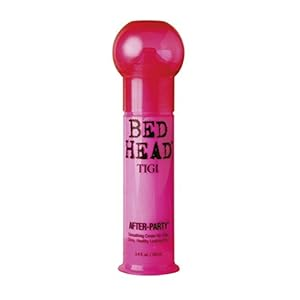

In [78]:
# Extract product information for specific ASINs to display images
color_club = meta_data_df.loc[meta_data_df['ASIN'] == "B00A1Y177A"]
print(f"Product details for Color Club: {color_club}")

# Displaying image of the product
from IPython import display
display.Image(color_club.loc[200571]["Image"])

# Another example with a different product
bed_head = meta_data_df.loc[meta_data_df['ASIN'] == "B001EWF2SI"]
print(f"Product details for Bed Head: {bed_head}")
display.Image(bed_head.loc[60398]["Image"])


##FINAL EVALUATION:
The final recommendation model using SVD yielded a RMSE of 1.0820 meaning that, on average, our predicted review scores for Amazon buyers were 1.0820 points off of the true value of review scores. This score is more than half a point drop from our baseline model. On a review scale of 1- 5, we believe that is a significant improvement.

The model also has other features that greatly improves the personalization of a post-purchase marketing email:

No repeat products. The model will not recommend items that the buyer has already purchased. This helps improve product discoverability.
Prioritizes the best match for the buyer. Whether the model is recommended through the catalog of products, or through a sub category, it will always deliver N number of the top predicted reviews for a buyer.
Subcategory filtering. The model allows for filtering beauty products based on six subcategories, allowing a more refined search.
Image retrieval. The model converts the URL to an image and delivers this image alongside recommended titles and descriptions.